In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Estilo dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        _, n_tokens, _ = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf) 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        attn_weights_viz = attn_weights.clone()
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec, attn_weights_viz  # Return attention weights


class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalSelfAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)

    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        context_vecs = [out[0] for out in head_outputs]
        attn_weights = [out[1] for out in head_outputs]

        context_vec = torch.cat(context_vecs, dim=-1)
        attn_weights = torch.stack(attn_weights, dim=1)

        return self.out_proj(context_vec), attn_weights # Retun attention weights
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        attn_weights_viz = attn_weights.clone()
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec, attn_weights_viz # Return attention weights

> **Referências**
>
> 1. <https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention>
> 2. <https://github.com/rasbt/LLMs-from-scratch/blob/main/ch03/01_main-chapter-code/multihead-attention.ipynb>


# 1 Efeito do QKV Bias em Causal Attention

In [3]:
batch_size, seq_len, d_in = 5, 8, 20
d_out = 16
dropout = 0.1

x = torch.randn(batch_size, seq_len, d_in)

# Experimento 1: COM bias
torch.manual_seed(42)
attn_with_bias = CausalSelfAttention(d_in, d_out, seq_len, dropout, qkv_bias=True)
attn_with_bias.eval()
with torch.no_grad():
    ctx_bias, weights_bias = attn_with_bias(x)

# Experimento 2: SEM bias
torch.manual_seed(42)
attn_no_bias = CausalSelfAttention(d_in, d_out, seq_len, dropout, qkv_bias=False)
attn_no_bias.eval()
with torch.no_grad():
    ctx_no_bias, weights_no_bias = attn_no_bias(x)

# Selecionar primeiro batch para visualização
batch_idx = 0

## 1.1 Diferenças nos Padrões da Matriz de Atenção

Nas duas configurações verifica-se o padrão triangular inferior, onde cada token só pode atender a si mesmo e aos tokens anteriores.

Sem o bias, as projeções Q e K dependem puramente do produto escalar dos embeddings transformados. Isso resulta em scores de atenção com maior variância, pois não há termo aditivo para "suavizar" a distribuição. O bias atua como um regularizador implícito que distribui a atenção de forma mais uniforme.

* COM bias (qkv_bias=True): 
    - Distribuição de atenção mais uniforme ao longo das posições permitidas. 
    - Os pesos decaem gradualmente: Q8 distribui atenção de forma relativamente equilibrada (0.11, 0.12, 0.13, 0.19, 0.12, 0.10, 0.11, 0.12).
    - Menor concentração em posições específicas.

* SEM bias (qkv_bias=False): 
    - Distribuição mais concentrada e com picos mais pronunciados.
    - Padrões de atenção mais "spiky": Q5 concentra 0.38 em K4, Q6 concentra 0.31 em K5.
    - Maior variabilidade entre posições, com alguns tokens recebendo atenção desproporcional.


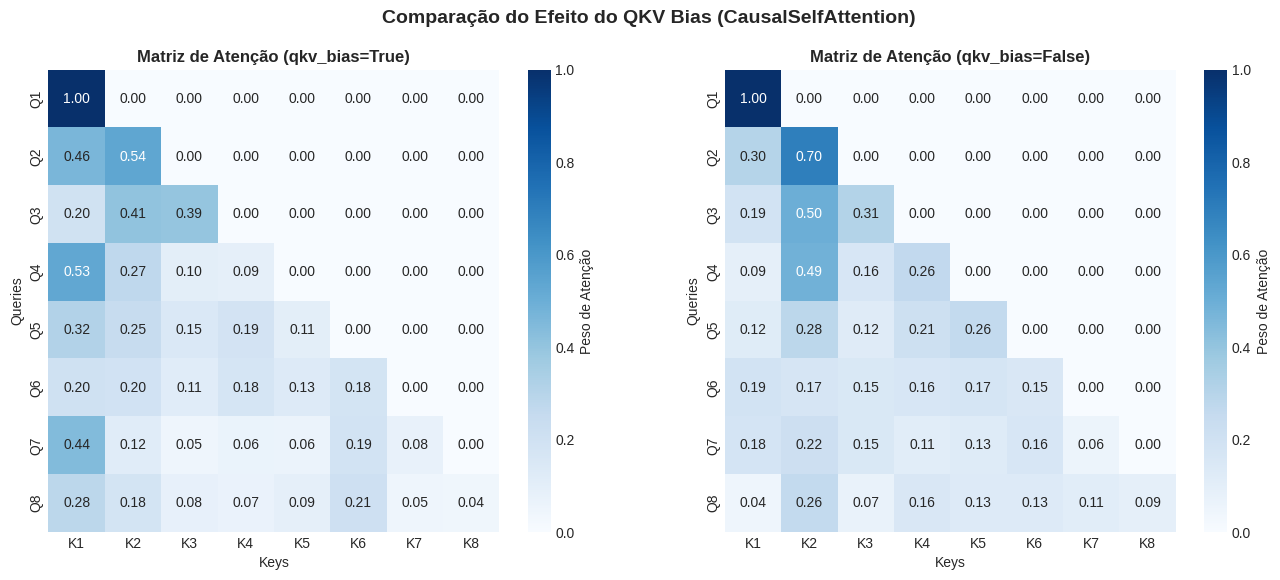

In [4]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparação do Efeito do QKV Bias (CausalSelfAttention)', 
                fontsize=14, fontweight='bold')

sns.heatmap(weights_bias[batch_idx].numpy(), 
            ax=axes[0], cmap='Blues', annot=True, fmt='.2f',
            xticklabels=[f'K{i+1}' for i in range(seq_len)],
            yticklabels=[f'Q{i+1}' for i in range(seq_len)],
            annot_kws={"size": 10},
            cbar_kws={'label': 'Peso de Atenção'})
_ = axes[0].set_title('Matriz de Atenção (qkv_bias=True)', fontweight='bold')
_ = axes[0].set_xlabel('Keys')
_ = axes[0].set_ylabel('Queries')

sns.heatmap(weights_no_bias[batch_idx].numpy(), 
            ax=axes[1], cmap='Blues', annot=True, fmt='.2f',
            xticklabels=[f'K{i+1}' for i in range(seq_len)],
            yticklabels=[f'Q{i+1}' for i in range(seq_len)],
            annot_kws={"size": 10},
            cbar_kws={'label': 'Peso de Atenção'})
_ = axes[1].set_title('Matriz de Atenção (qkv_bias=False)', fontweight='bold')
_ = axes[1].set_xlabel('Keys')
_ = axes[1].set_ylabel('Queries')

## 1.2 Alterações na Distribuição dos Vetores de Contexto

O bias em W_v adiciona um offset constante aos vetores de valor, que se propaga para os vetores de contexto após a ponderação. Isso explica a maior amplitude e os padrões mais estruturados na versão com bias.

* COM bias (qkv_bias=True):

    - Range de valores: aproximadamente [-1.99, 1.07]
    - Padrões mais consistentes entre dimensões (colunas com cores similares)
    - Dimensões d1, d2, d4-d7 apresentam valores predominantemente negativos
    - Dimensão d3 consistentemente positiva


* SEM bias (qkv_bias=False):

    - Range de valores: aproximadamente [-1.18, 0.70]
    - Menor amplitude geral comparado à versão com bias
    - Padrões mais heterogêneos entre tokens
    - Dimensão d13 apresenta valores consistentemente altos (amarelo)

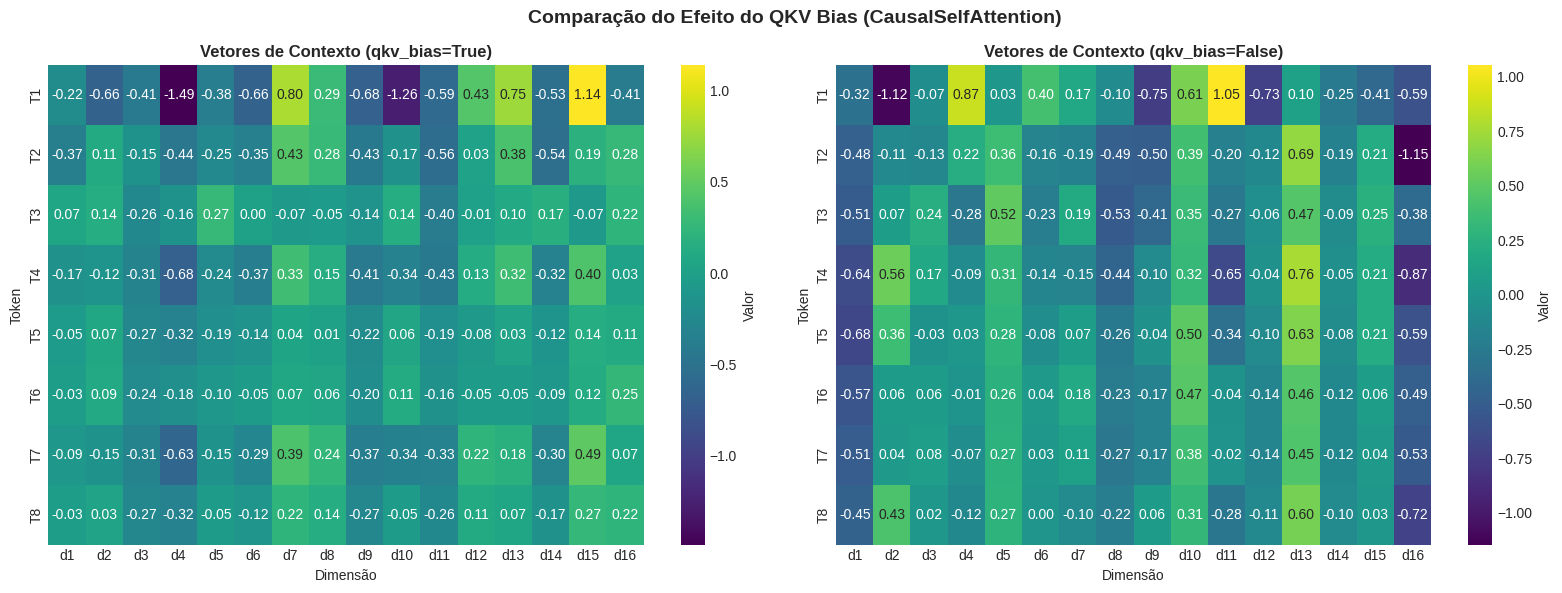

In [5]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparação do Efeito do QKV Bias (CausalSelfAttention)', 
                fontsize=14, fontweight='bold')

sns.heatmap(ctx_bias[batch_idx].numpy(), 
            ax=axes[0], cmap='viridis', annot=True, fmt='.2f',
            xticklabels=[f'd{i+1}' for i in range(d_out)],
            yticklabels=[f'T{i+1}' for i in range(seq_len)],
            annot_kws={"size": 10},
            cbar_kws={'label': 'Valor'})
_ = axes[0].set_title('Vetores de Contexto (qkv_bias=True)', fontweight='bold')
_ = axes[0].set_xlabel('Dimensão')
_ = axes[0].set_ylabel('Token')

sns.heatmap(ctx_no_bias[batch_idx].numpy(), 
            ax=axes[1], cmap='viridis', annot=True, fmt='.2f',
            xticklabels=[f'd{i+1}' for i in range(d_out)],
            yticklabels=[f'T{i+1}' for i in range(seq_len)],
            annot_kws={"size": 10},
            cbar_kws={'label': 'Valor'})
_ = axes[1].set_title('Vetores de Contexto (qkv_bias=False)', fontweight='bold')
_ = axes[1].set_xlabel('Dimensão')
_ = axes[1].set_ylabel('Token')

plt.tight_layout()

## 1.3 Papel do Bias nas Projeções Lineares

- Suaviza a distribuição de atenção: O termo aditivo nos scores Q·Kᵀ desloca uniformemente todos os valores antes do softmax, reduzindo a "peakyness" da distribuição resultante.

- Aumenta a amplitude das representações: Os vetores de contexto com bias apresentam maior range, o que pode ser benéfico para expressividade mas também pode requerer normalização mais cuidadosa.

- Introduz um "prior" de atenção: O bias permite que o modelo aprenda um padrão de atenção baseline independente do conteúdo de entrada, útil especialmente em camadas iniciais onde as representações ainda são brutas.

# 2 Comparação do Número de Heads


In [6]:
batch_size, seq_len, d_in = 5, 6, 4
d_out = 4
dropout = 0.1

x = torch.randn(batch_size, seq_len, d_in)

# Experimento 1: 2 heads (head_dim = 2)
torch.manual_seed(42)
attn_2heads = MultiHeadAttention(d_in, d_out, seq_len, dropout, num_heads=2, qkv_bias=False)
attn_2heads.eval()
with torch.no_grad():
    ctx_2h, weights_2h = attn_2heads(x)

# Experimento 2: 4 heads (head_dim = 1)
torch.manual_seed(42)
attn_4heads = MultiHeadAttention(d_in, d_out, seq_len, dropout, num_heads=4, qkv_bias=False)
attn_4heads.eval()
with torch.no_grad():
    ctx_4h, weights_4h = attn_4heads(x)

batch_idx = 0

## 2.1 Influência do Número de Heads nos Padrões de Atenção

* 2 Heads (head_dim=2):
    * Head 1: Apresenta atenção relativamente distribuída, com leve preferência por K4 em algumas queries, por exemplo (Q4, K4)=0.44. Padrão mais uniforme nas linhas inferiores.

    * Head 2: Mostra concentração mais forte em K3 para várias queries (Q3, K1)=0.42, (Q4, K3)=0.41. Padrão um pouco diferente do Head 1.

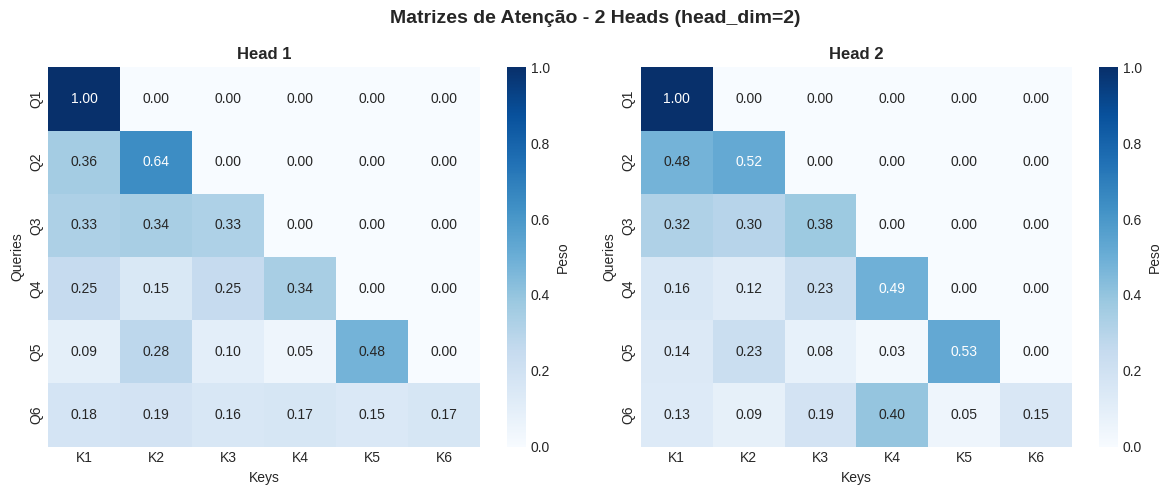

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Matrizes de Atenção - 2 Heads (head_dim=2)', fontsize=14, fontweight='bold')

for h in range(2):
    sns.heatmap(weights_2h[batch_idx, h].numpy(), 
                ax=axes[h], cmap='Blues', annot=True, fmt='.2f',
                xticklabels=[f'K{i+1}' for i in range(seq_len)],
                yticklabels=[f'Q{i+1}' for i in range(seq_len)],
                cbar_kws={'label': 'Peso'})
    axes[h].set_title(f'Head {h+1}', fontweight='bold')
    axes[h].set_xlabel('Keys')
    axes[h].set_ylabel('Queries')

plt.tight_layout()

* 4 Heads (head_dim=2):
    - Head 1: Forte concentração em (Q4, K4)=0.50
    - Head 2: Distribuição mais uniforme, especialmente em Q5 e Q6
    - Head 3: Concentração pronunciada em K3, (Q3, K1)=0.40, (Q4, K3)=0.47 e (Q5, K3)=0.30
    - Head 4: Padrão mais equilibrado, mas ainda com preferências (Q4, K2)=0.34


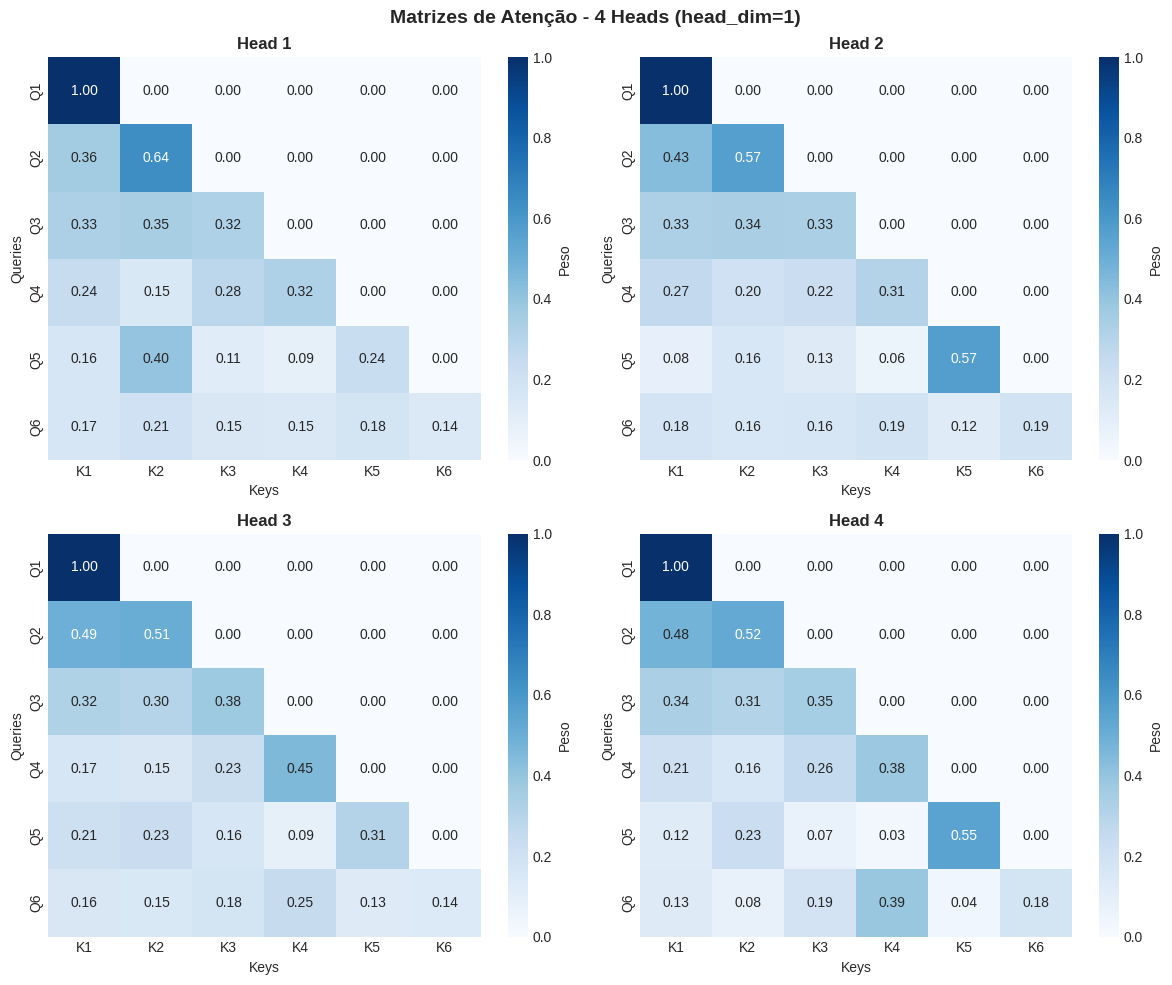

In [8]:

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Matrizes de Atenção - 4 Heads (head_dim=1)', fontsize=14, fontweight='bold')

for h in range(4):
    row, col = h // 2, h % 2
    sns.heatmap(weights_4h[batch_idx, h].numpy(), 
                ax=axes[row, col], cmap='Blues', annot=True, fmt='.2f',
                xticklabels=[f'K{i+1}' for i in range(seq_len)],
                yticklabels=[f'Q{i+1}' for i in range(seq_len)],
                cbar_kws={'label': 'Peso'})
    axes[row, col].set_title(f'Head {h+1}', fontweight='bold')
    axes[row, col].set_xlabel('Keys')
    axes[row, col].set_ylabel('Queries')

plt.tight_layout()

Com head_dim=1, cada head computa atenção usando apenas um único escalar para Q e K. Isso significa que o score de atenção q*k é literalmente a multiplicação de dois números, limitando severamente a capacidade de discriminação.

## 2.2 Diferentes Heads Capturam Informações Distintas?

A correlação entre os 2 heads é ~0.95, extremamente alta. Provavelmente os dois heads estão aprendendo padrões de atenção muito similares. Com head_dim=2, cada head tem apenas 2 dimensões para computar similaridade, o que limita a diversidade de padrões possíveis, ou talvez seja apenas a entrada aleatória que estamos usando, não existem informações distintas a serem aprendidas.

In [12]:
corr_2h = np.corrcoef(weights_2h[batch_idx, 0].flatten().numpy(), 
                        weights_2h[batch_idx, 1].flatten().numpy())[0, 1]
print(f"2 Heads - Correlação entre heads: {corr_2h:.4f}")

corrs_4h = []
for i in range(4):
    for j in range(i+1, 4):
        c = np.corrcoef(weights_4h[batch_idx, i].flatten().numpy(),
                        weights_4h[batch_idx, j].flatten().numpy())[0, 1]
        corrs_4h.append(c)

2 Heads - Correlação entre heads: 0.9567


## 2.3 Limitações de Aumentar o Número de Heads Mantendo d_out Fixo

Os heatmaps mostram que os vetores de contexto são praticamente idênticos entre 2 heads e 4 heads.

$$ head_{dim} = d_{out} / num_{heads} $$

Configurações

| Configuração | `d_out` | `num_heads` | `head_dim` |
|--------------|---------|-------------|------------|
| 2 Heads      | 4       | 2           | 2          |
| 4 Heads      | 4       | 4           | 1          |

O `head_dim` determina quantas dimensões cada head usa para calcular a similaridade entre queries e keys. Então com `head_dim`=2 na configuração 1 temos:

$$ score = q_{1} \cdot k_{1} + q_{2} \cdot k_{2} $$

O head pode aprender/olhar para duas características diferentes simultaneamente e combiná-las (produto escalar em ℝ²). Com `head_dim`=1 na configuração 2 temos:

$$ score = q_{1} \cdot k_{1} $$

fazendo com que o head só consiga comparar apenas uma única característica.

Sendo assim, 4 heads com `head_dim`=1 têm capacidade total similar a 2 heads com `head_dim`=2. A diversidade de perspectivas esperada pelo aumento do número de heads é anulada pela capacidade individual limitada de cada novo head.

Existe um _trade-off_ que devemos considerar:

* **Poucos heads grandes:** cada head captura relações ricas, mas poucas "perspectivas"

* **Muitos heads pequenos:** múltiplas "perspectivas", mas cada uma muito superficial

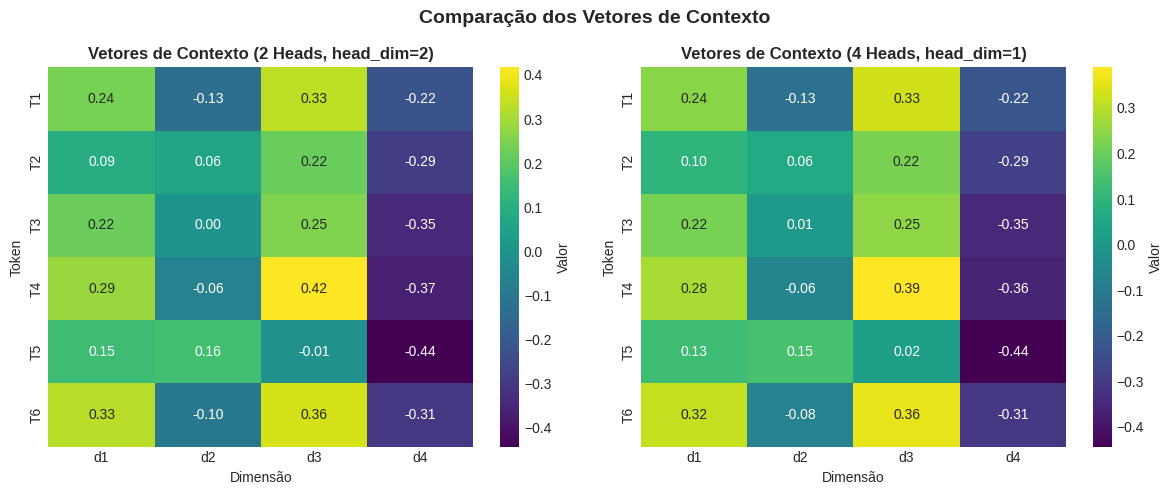

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Comparação dos Vetores de Contexto', fontsize=14, fontweight='bold')

sns.heatmap(ctx_2h[batch_idx].numpy(), 
            ax=axes[0], cmap='viridis', annot=True, fmt='.2f',
            xticklabels=[f'd{i+1}' for i in range(d_out)],
            yticklabels=[f'T{i+1}' for i in range(seq_len)],
            cbar_kws={'label': 'Valor'})
axes[0].set_title('Vetores de Contexto (2 Heads, head_dim=2)', fontweight='bold')
axes[0].set_xlabel('Dimensão')
axes[0].set_ylabel('Token')

sns.heatmap(ctx_4h[batch_idx].numpy(), 
            ax=axes[1], cmap='viridis', annot=True, fmt='.2f',
            xticklabels=[f'd{i+1}' for i in range(d_out)],
            yticklabels=[f'T{i+1}' for i in range(seq_len)],
            cbar_kws={'label': 'Valor'})
axes[1].set_title('Vetores de Contexto (4 Heads, head_dim=1)', fontweight='bold')
axes[1].set_xlabel('Dimensão')
axes[1].set_ylabel('Token')

plt.tight_layout()